In [12]:
import glam
import pandas as pd
import numpy as np
import os.path

import matplotlib.pyplot as plt

In [13]:
np.random.seed(23) # from random.org

# 3.1. Hierarchical GLAM estimation and out of sample prediction

## Load data

In [14]:
# Load data
sufix = '_Like_FixBin5'
data = pd.read_csv('data/FF2018_data/GlamDataFF2018_Like_Bin_v2.csv')
# Subset only necessary columns
data = data[['subject', 'trial', 'choice', 'rt',
         'item_value_0', 'item_value_1',
         'gaze_0', 'gaze_1']]
data.head()

,subject,trial,choice,rt,item_value_0,item_value_1,gaze_0,gaze_1
0,0,0,0,2009,0.0,0.0,0.568396,0.431604
1,0,1,0,3371,5.0,4.0,0.762332,0.237668
2,0,2,1,1700,0.0,5.0,0.446809,0.553191
3,0,3,1,7466,1.0,2.0,0.532352,0.467648
4,0,4,1,1889,5.0,5.0,0.529736,0.470264


## Split data in training and test sets

In [15]:
train_data = pd.DataFrame()
test_data = pd.DataFrame()

for subject in data.subject.unique():
    subject_data = data[data['subject'] == subject].copy().reset_index(drop=True)
    n_trials = len(subject_data)
    
    subject_train = subject_data.iloc[np.arange(0, n_trials, 2)].copy()
    subject_test = subject_data.iloc[np.arange(1, n_trials, 2)].copy()

    test_data = pd.concat([test_data, subject_test])
    train_data = pd.concat([train_data, subject_train])

test_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_test'+sufix+'.csv'))
train_data.to_csv(str('data/FF2018_data/GlamDataFF2018_preprocessed_train'+sufix+'.csv'))

print('Split data into training ({} trials) and test ({} trials) sets...'.format(len(train_data), len(test_data)))

Split data into training (1980 trials) and test (1980 trials) sets...


## Hierarchical GLAM estimation

### 1. full GLAM

In [16]:
# Fitting full GLAM
print('Fitting full GLAM hierarchically...')

glam_full = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy')):
    glam_full.make_model('hierarchical', gamma_bounds=(-1, 1), t0_val=0)
    glam_full.fit(method='ADVI', n_advi=200000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_full.estimates = np.load(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'))   
# Save parameter estimates
#np.save(str('results/estimates/glam_FF2018_full_hierarchical_cv'+sufix+'.npy'), glam_full.estimates)
#pd.DataFrame(glam_full.estimates)

Fitting full GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


In [17]:
# Predictions
print('Predicting test set data using full GLAM...')
glam_full.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv')):
    glam_full.predict(n_repeats=50)
    glam_full.prediction.to_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...')
    glam_full.prediction = pd.read_csv(str('results/predictions/glam_FF2018_full_hierarchical_cv'+sufix+'.csv'))

glam_full.prediction.head()

Predicting test set data using full GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...
  Found old hierarchical full GLAM predictions in "results/predictions". Skipping prediction...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,3075.0,0.0,0.0,5.0,0.762332,4.0,0.237668
1,0.0,1.0,1409.0,0.0,0.0,5.0,0.762332,4.0,0.237668
2,0.0,2.0,2886.0,0.0,0.0,5.0,0.762332,4.0,0.237668
3,0.0,3.0,3200.0,0.0,0.0,5.0,0.762332,4.0,0.237668
4,0.0,4.0,2049.0,0.0,0.0,5.0,0.762332,4.0,0.237668


### 1. no-bias GLAM

In [18]:
# Fitting no-bias GLAM
print('Fitting no-bias GLAM hierarchically...')

glam_nobias = glam.GLAM(train_data)

if not os.path.exists(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy')):
    glam_nobias.make_model('hierarchical', gamma_val=1.0, t0_val=0)
    glam_nobias.fit(method='ADVI', n_advi=200000)
else:
    print('  Found old parameter estimates in "results/estimates". Skipping estimation...')
    glam_nobias.estimates = np.load(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'))
    
# Save parameter estimates
#np.save(str('results/estimates/glam_FF2018_nobias_hierarchical_cv'+sufix+'.npy'), glam_nobias.estimates)
#pd.DataFrame(glam_nobias.estimates)

Fitting no-bias GLAM hierarchically...
  Found old parameter estimates in "results/estimates". Skipping estimation...


In [19]:
# Predictions
print('Predicting test set data using no-bias GLAM...')
glam_nobias.exchange_data(test_data)

if not os.path.exists(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv')):
    glam_nobias.predict(n_repeats=50)
    glam_nobias.prediction.to_csv(str('results/predictions/glam_nobias_hierarchical_cv'+sufix+'.csv'), index=False)
else:
    print('  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...')
    glam_nobias.prediction = pd.read_csv(str('results/predictions/glam_FF2018_nobias_hierarchical_cv'+sufix+'.csv'))

glam_nobias.prediction.head()

Predicting test set data using no-bias GLAM...
Replaced attached data (1980 trials) with new data (1980 trials)...
  Found old hierarchical no-bias GLAM predictions in "results/predictions". Skipping prediction...


,choice,repeat,rt,subject,trial,item_value_0,gaze_0,item_value_1,gaze_1
0,0.0,0.0,1827.0,0.0,0.0,5.0,0.762332,4.0,0.237668
1,1.0,1.0,3038.0,0.0,0.0,5.0,0.762332,4.0,0.237668
2,1.0,2.0,1920.0,0.0,0.0,5.0,0.762332,4.0,0.237668
3,1.0,3.0,3512.0,0.0,0.0,5.0,0.762332,4.0,0.237668
4,1.0,4.0,5662.0,0.0,0.0,5.0,0.762332,4.0,0.237668


## 2. Plot fit

Close Figure to continue...


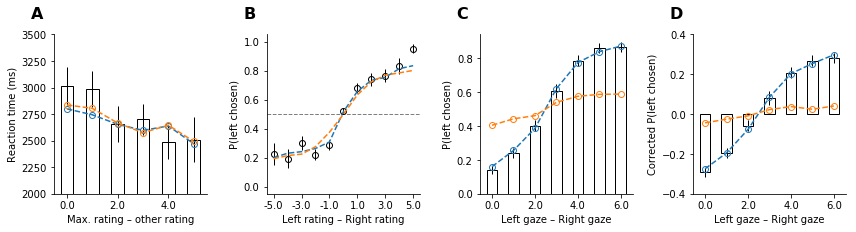

In [20]:
print('Close Figure to continue...')
#glam.plot_fit(test_data, [glam_full.prediction]);
glam.plot_fit(test_data, [glam_full.prediction,glam_nobias.prediction]);

plt.show()

## Parameters for full hierarchical model

In [25]:
params_participant = glam_full.estimates.item(0)
params_participant = pd.DataFrame.from_dict(glam_full.estimates.item(0))

In [26]:
params_participant

,SNR,SNR_mu,SNR_sd,b,gamma,gamma_mu,gamma_sd,p_error,s,t0,tau,tau_mu,tau_sd,v,v_mu,v_sd
0,171.89,173.33,26.33,1.0,-0.52,-0.49,0.32,0.05,0.007405,0.0,1.62,1.77,1.01,0.000045,0.000051,0.000011
1,169.91,173.33,26.33,1.0,-0.03,-0.49,0.32,0.05,0.010183,0.0,1.40,1.77,1.01,0.000062,0.000051,0.000011
2,156.71,173.33,26.33,1.0,0.34,-0.49,0.32,0.05,0.008641,0.0,2.28,1.77,1.01,0.000056,0.000051,0.000011
3,176.83,173.33,26.33,1.0,-0.66,-0.49,0.32,0.05,0.007556,0.0,2.02,1.77,1.01,0.000041,0.000051,0.000011
4,101.66,173.33,26.33,1.0,-0.71,-0.49,0.32,0.05,0.007086,0.0,3.81,1.77,1.01,0.000066,0.000051,0.000011
5,119.05,173.33,26.33,1.0,-0.36,-0.49,0.32,0.05,0.007743,0.0,0.31,1.77,1.01,0.000060,0.000051,0.000011
6,167.22,173.33,26.33,1.0,-0.64,-0.49,0.32,0.05,0.010272,0.0,0.69,1.77,1.01,0.000067,0.000051,0.000011
7,163.15,173.33,26.33,1.0,-0.41,-0.49,0.32,0.05,0.008278,0.0,1.31,1.77,1.01,0.000044,0.000051,0.000011
8,177.02,173.33,26.33,1.0,-0.97,-0.49,0.32,0.05,0.008532,0.0,0.70,1.77,1.01,0.000054,0.000051,0.000011
9,173.64,173.33,26.33,1.0,-0.50,-0.49,0.32,0.05,0.008618,0.0,2.10,1.77,1.01,0.000045,0.000051,0.000011


In [27]:
print ("Mean gamma " +  str(params_participant['gamma'].mean()))

Mean gamma -0.5487878787878788


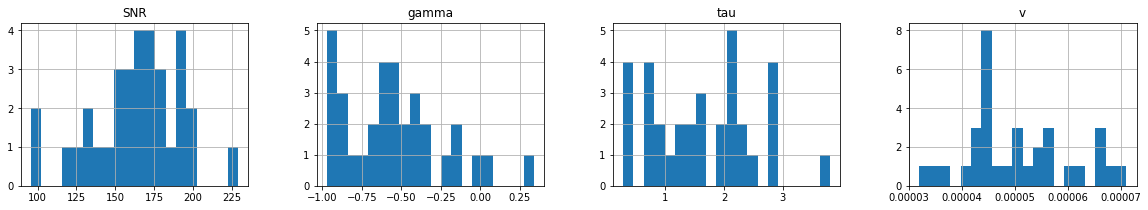

In [28]:
hist = params_participant[['SNR','gamma','tau','v']].hist(figsize = [20,3] , layout=[1,4],bins = 20)

## [END] 

In [11]:
testa = glam_nobias.prediction

In [12]:
xlims =(0, 10)

# Compute relevant variables
df = glam.plots.add_difficulty(testa)

# Compute summary statistics
subject_means = df.groupby(['subject', 'difficulty']).rt.mean()
means = subject_means.groupby('difficulty').mean()[xlims[0]:xlims[1]]
sems = subject_means.groupby('difficulty').sem()[xlims[0]:xlims[1]]


In [13]:
means

difficulty
0.0    2836.438676
1.0    2804.343664
2.0    2666.336049
3.0    2574.893441
4.0    2645.930315
5.0    2492.845359
Name: rt, dtype: float64